<a href="https://colab.research.google.com/github/NicoAN42/SKRPSI/blob/main/2022_Nadam_All_Lyr_Cbam_tt_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount dataset
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from tensorflow.keras.layers import Conv2D, Input, concatenate, Activation, InputLayer, Dense, Reshape, Flatten, Add, multiply, Permute, Lambda, Concatenate
from tensorflow.keras.layers import LeakyReLU,ReLU, MaxPooling2D, BatchNormalization,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.activations import softmax,sigmoid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout,SpatialDropout2D,GaussianDropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras import backend as K
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score
from sklearn.model_selection import StratifiedKFold
import os
import random
import shutil

In [3]:
#from tensorflow.keras.optimizers import SGD

In [4]:
CLASS = 3
#sourcepath isi semua data train, folder valid kosongin datanya sisai folder classnya
sourcePath = '/content/drive/MyDrive/Colab Notebooks/Dataset 5'
train_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 5/train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 5/valid'
test_path = '/content/drive/MyDrive/Colab Notebooks/Dataset 5/test'
attention_module = 'cbam_block'
#nico

In [5]:
classLabels =['covid','normal', 'pneumonia']

In [6]:
def attach_attention_module(net, attention_module):
  #if attention_module == 'se_block': # SE_block
    #net = se_block(net)
  if attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net)
  else:
    raise Exception("'{}' is not supported attention module!".format(attention_module))

  return net

In [7]:
def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature


In [8]:
def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

In [9]:
def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])

In [10]:
input = Input(shape=(256,256,3))

In [11]:
#Layer 1
model = layers.Conv2D(32, (3,3), padding='same', name='conv_1', activation = 'relu')(input)
model = layers.BatchNormalization(name='norm_1')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides= 2)(model)
attention_module = 'cbam_block'
y = attach_attention_module(model, attention_module)
model =  tensorflow.keras.layers.add([model, y])


In [12]:
#Layer 2
model = layers.Conv2D(64, (3,3), padding='same', name='conv_2', activation = 'relu')(model)
model = layers.Dropout(0.1)(model)
model = layers.BatchNormalization(name='norm_2')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)

attention_module = 'cbam_block'
y = attach_attention_module(model, attention_module)
model =  tensorflow.keras.layers.add([model, y])


In [13]:
# Layer 3
model = layers.Conv2D(64, (3,3), padding='same', name='conv_3', activation = 'relu')(model)
model = layers.BatchNormalization(name='norm_3')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)

attention_module = 'cbam_block'
y = attach_attention_module(model, attention_module)
model =  tensorflow.keras.layers.add([model, y])



In [14]:
# Layer 4
model = layers.Conv2D(128, (3,3), padding='same', name='conv_4', activation = 'relu')(model)
model = layers.Dropout(0.2)(model)
model = layers.BatchNormalization(name='norm_4')(model)
model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)

attention_module = 'cbam_block'
y = attach_attention_module(model, attention_module)
model =  tensorflow.keras.layers.add([model, y])


In [15]:
# Layer 5
model = layers.Conv2D(256, (3,3), padding='same', name='conv_5', activation = 'relu')(model)
layer = layers.Conv2D(256, (3,3), padding='same', name='conv_5', activation = 'relu')
batch = layers.BatchNormalization(name='norm_5')
model = layers.Dropout(0.2)(model)
model = layers.BatchNormalization(name='norm_5')(model)
#model = layers.MaxPooling2D(pool_size=(2, 2), strides = 2)(model)

In [16]:
model = layers.Flatten()(model)
model = layers.Dense(128, activation = 'relu')(model)
model = layers.Dropout(0.2)(model)
output = layers.Dense(3,Activation('softmax'))(model)
model = Model(input, output)

In [17]:
print(input)

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [18]:
opt = Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

In [19]:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )

In [20]:
print(model.summary())
print(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 256, 256, 32  128         ['conv_1[0][0]']                 
                                )                                                             

In [21]:
X = []
Y = []
def transferBetweenFolders(source, dest, splitRate): 
    global sourceFiles
    sourceFiles=os.listdir(source)
    if(len(sourceFiles)!=0):
        transferFileNumbers=int(len(sourceFiles)*splitRate)
        transferIndex=random.sample(range(0, len(sourceFiles)), transferFileNumbers)
        for eachIndex in transferIndex:
            shutil.move(source+str(sourceFiles[eachIndex]), dest+str(sourceFiles[eachIndex]))
    else:
        print("No file moved. Source empty!")
        

In [22]:
def transferAllClassBetweenFolders(source, dest, splitRate):
    for label in classLabels:
        transferBetweenFolders(sourcePath+'/'+source+'/'+label+'/', 
                               sourcePath+'/'+dest+'/'+label+'/', 
                               splitRate)
#First cut all images from validation to train (if any exists)
transferAllClassBetweenFolders('valid', 'train', 1.0)
#no valid
transferAllClassBetweenFolders('test', 'train', 1.0)

No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!


In [23]:
def prepareNameWithLabels(folderName):
    sourceFiles=os.listdir(sourcePath+'/train/'+folderName)
    for val in sourceFiles:
        X.append(val)
        for i in range(len(classLabels)):
          if(folderName==classLabels[i]):
              Y.append(i)
# Organize file names and class labels in X and Y variables
for i in range(len(classLabels)):
  prepareNameWithLabels(classLabels[i])

def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='micro')
    f1Score=f1_score(y_true, y_pred, average='micro') 
    recall = recall_score(y_true, y_pred, average='micro')
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    print("Recall : {}".format(recall))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)

    print("***----------------------------***")  
    return accuracy, precision, f1Score, recall

In [24]:
transferAllClassBetweenFolders('valid', 'train', 1.0)
transferAllClassBetweenFolders('test', 'train', 1.0)
X=np.asarray(X)
Y=np.asarray(Y)

print(X)
print(Y)

skf = StratifiedKFold(n_splits=5
                      , shuffle=True)
skf.get_n_splits(X, Y)
print(skf)
print(skf.get_n_splits(X,Y))
print(skf.split(X,Y))
foldNum=0
overAllAcc = 0
overAllPrec = 0
overAllf1 = 0
overAllRec = 0

No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
['COVID(43).png' 'COVID(104).png' 'COVID(11).png' ...
 'person98_virus_182.jpeg' 'person99_virus_183.jpeg'
 'person97_virus_180.jpeg']
[0 0 0 ... 2 2 2]
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
5
<generator object _BaseKFold.split at 0x7f05de26b750>


trn_indx: 2268 test_indx: 567
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Results for fold 1
2268
567
Found 2268 images belonging to 3 classes.
Found 567 images belonging to 3 classes.
Epoch 1/25
71/71 - 725s - loss: 7.8197 - accuracy: 0.7324 - 725s/epoch - 10s/step
Epoch 2/25
71/71 - 26s - loss: 0.6375 - accuracy: 0.7760 - 26s/epoch - 361ms/step
Epoch 3/25
71/71 - 26s - loss: 0.5940 - accuracy: 0.8038 - 26s/epoch - 361ms/step
Epoch 4/25
71/71 - 26s - loss: 0.5092 - accuracy: 0.8183 - 26s/epoch - 360ms/step
Epoch 5/25
71/71 - 25s - loss: 0.4439 - accuracy: 0.8523 - 25s/epoch - 356ms/step
Epoch 6/25
71/71 - 25s - loss: 0.4382 - accuracy: 0.8576 - 25s/epoch - 357ms/step
Epoch 7/25
71/71 - 25s - loss: 0.4777 - accuracy: 0.8016 - 25s/epoch - 358ms/step
Epoch 8/25
71/71 - 25s - loss: 0.6431 - accuracy: 0.8064 - 25s/epoch - 359ms/step
Epoch 9/25
71/71 - 26s - loss

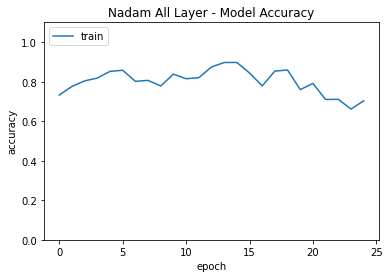

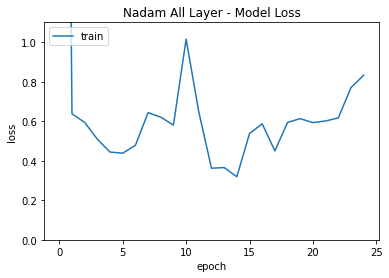

***Performance Data***
Accuracy  : 0.855379188712522
Precision : 0.855379188712522
f1Score : 0.855379188712522
Recall : 0.855379188712522
[[169   3  17]
 [  0 133  57]
 [  2   3 183]]
***----------------------------***
18/18 [==============================] - 7s 355ms/step - loss: 0.7864 - accuracy: 0.8554
***-----------------------------------------------***
Overall Accuracy:  0.855379188712522
Overall Precision:  0.855379188712522
Overall f1Score:  0.855379188712522
Overall Recall:  0.855379188712522
***------------------End of Line------------------***
trn_indx: 2268 test_indx: 567
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Results for fold 2
2268
567
Found 2268 images belonging to 3 classes.
Found 567 images belonging to 3 classes.
Epoch 1/25
71/71 - 25s - loss: 0.8951 - accuracy: 0.7324 - 25s/epoch - 357ms/step
Epoch 2/25
71/71 - 25s - loss: 0.7262 - accuracy: 0.7187 - 25s/epoch - 357ms/step
Epoch 3/25
71/71 - 25s - loss: 0.5911 - accura

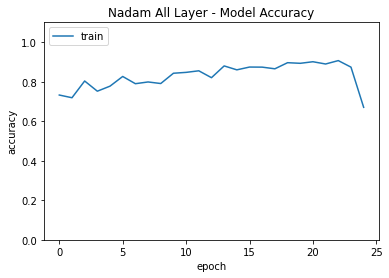

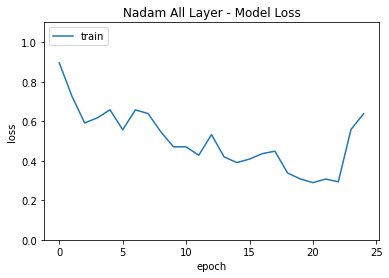

***Performance Data***
Accuracy  : 0.6490299823633157
Precision : 0.6490299823633157
f1Score : 0.6490299823633157
Recall : 0.6490299823633157
[[178   0  11]
 [  0  12 178]
 [ 10   0 178]]
***----------------------------***
18/18 [==============================] - 6s 345ms/step - loss: 1.0293 - accuracy: 0.6490
***-----------------------------------------------***
Overall Accuracy:  0.7522045855379189
Overall Precision:  0.7522045855379189
Overall f1Score:  0.7522045855379189
Overall Recall:  0.7522045855379189
***------------------End of Line------------------***
trn_indx: 2268 test_indx: 567
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Results for fold 3
2268
567
Found 2268 images belonging to 3 classes.
Found 567 images belonging to 3 classes.
Epoch 1/25
71/71 - 25s - loss: 0.7772 - accuracy: 0.6570 - 25s/epoch - 355ms/step
Epoch 2/25
71/71 - 25s - loss: 1.2049 - accuracy: 0.5428 - 25s/epoch - 351ms/step
Epoch 3/25
71/71 - 26s - loss: 1.0840 

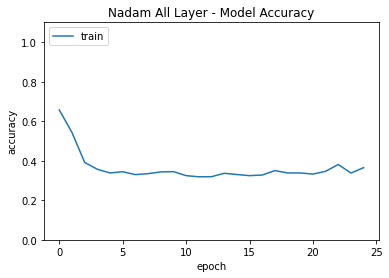

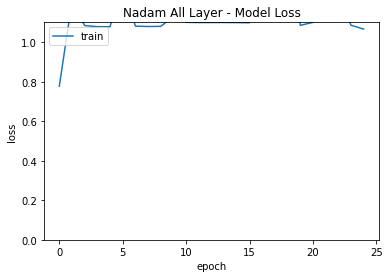

***Performance Data***
Accuracy  : 0.37037037037037035
Precision : 0.37037037037037035
f1Score : 0.37037037037037035
Recall : 0.37037037037037035
[[ 21   0 168]
 [  1   0 188]
 [  0   0 189]]
***----------------------------***
18/18 [==============================] - 6s 359ms/step - loss: 1.1983 - accuracy: 0.3704
***-----------------------------------------------***
Overall Accuracy:  0.6249265138154027
Overall Precision:  0.6249265138154027
Overall f1Score:  0.6249265138154027
Overall Recall:  0.6249265138154027
***------------------End of Line------------------***
trn_indx: 2268 test_indx: 567
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Results for fold 4
2268
567
Found 2268 images belonging to 3 classes.
Found 567 images belonging to 3 classes.
Epoch 1/25
71/71 - 25s - loss: 1.2001 - accuracy: 0.3417 - 25s/epoch - 353ms/step
Epoch 2/25
71/71 - 25s - loss: 1.0888 - accuracy: 0.3439 - 25s/epoch - 355ms/step
Epoch 3/25
71/71 - 25s - loss: 1.0

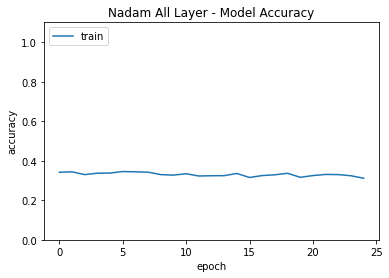

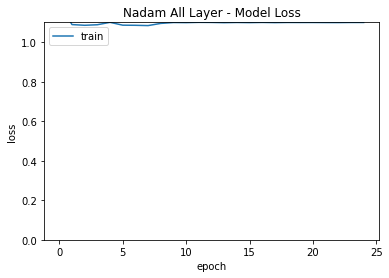

***Performance Data***
Accuracy  : 0.3350970017636684
Precision : 0.3350970017636684
f1Score : 0.3350970017636684
Recall : 0.3350970017636684
[[  0 188   0]
 [  0 190   0]
 [  0 189   0]]
***----------------------------***
18/18 [==============================] - 6s 358ms/step - loss: 1.0987 - accuracy: 0.3351
***-----------------------------------------------***
Overall Accuracy:  0.5524691358024691
Overall Precision:  0.5524691358024691
Overall f1Score:  0.5524691358024691
Overall Recall:  0.5524691358024691
***------------------End of Line------------------***
trn_indx: 2268 test_indx: 567
No file moved. Source empty!
No file moved. Source empty!
No file moved. Source empty!
Results for fold 5
2268
567
Found 2268 images belonging to 3 classes.
Found 567 images belonging to 3 classes.
Epoch 1/25
71/71 - 26s - loss: 1.0994 - accuracy: 0.3333 - 26s/epoch - 361ms/step
Epoch 2/25
71/71 - 26s - loss: 1.0990 - accuracy: 0.3148 - 26s/epoch - 361ms/step
Epoch 3/25
71/71 - 26s - loss: 1.0994 

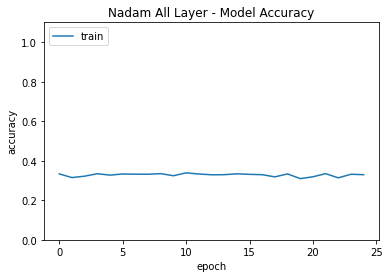

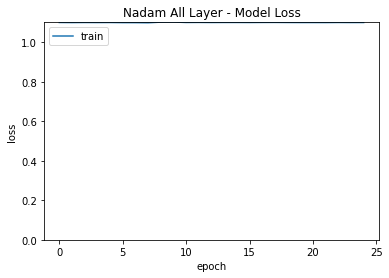

***Performance Data***
Accuracy  : 0.3350970017636684
Precision : 0.3350970017636684
f1Score : 0.3350970017636684
Recall : 0.3350970017636684
[[  0 188   0]
 [  0 190   0]
 [  0 189   0]]
***----------------------------***
18/18 [==============================] - 6s 353ms/step - loss: 1.0988 - accuracy: 0.3351
***-----------------------------------------------***
Overall Accuracy:  0.508994708994709
Overall Precision:  0.508994708994709
Overall f1Score:  0.508994708994709
Overall Recall:  0.508994708994709
***------------------End of Line------------------***


In [25]:
for train_index, val_index in skf.split(X, Y):
    print("trn_indx: %s test_indx: %s" % (len(train_index), len(val_index)))
    #First cut all images from validation to train (if any exists)
    transferAllClassBetweenFolders('valid', 'train', 1.0)
    #no valid
    transferAllClassBetweenFolders('test', 'train', 1.0)
    foldNum+=1
    print("Results for fold",foldNum)
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    print(len(X_train))
    print(len(X_val))
    # Move validation images of this fold from train folder to the validation folder
    for eachIndex in range(len(X_val)):
        classLabel=''
        for i in range(len(classLabels)):
          if(Y_val[eachIndex]==i):
              classLabel=classLabels[i]
        #Then, copy the validation images to the validation folder
        shutil.move(sourcePath+'/train/'+classLabel+'/'+X_val[eachIndex], 
                    #sourcePath+'/valid/'+classLabel+'/'+X_val[eachIndex])
        #without valid
                    sourcePath+'/test/'+classLabel+'/'+X_val[eachIndex])
        
    train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 32, shuffle=True)
    #without valid
    #valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 32, shuffle=True)
    test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(256,256), classes=['covid', 'normal', 'pneumonia'], class_mode = 'sparse', batch_size = 32, shuffle=False)

    history = model.fit(train_batches, 
                    #steps_per_epoch=sp_epoch, 
                    #without valid
                    #validation_data=valid_batches, 
                    #validation_steps=10, 
                    epochs=25, 
                    verbose=2)
    
    
    
    plt.plot(history.history['accuracy'])
    #plt.plot(history.history['val_accuracy'])
    plt.title('Nadam All Layer - Model Accuracy')
    plt.ylim(0,1.1)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    #plt.legend(['train', 'valid'], loc='upper left')
    #without valid
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('Nadam All Layer - Model Loss')
    plt.ylim(0,1.1)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train', 'valid'], loc='upper left')
    #without valid
    plt.legend(['train'], loc='upper left')
    plt.show()
    test_batches.reset()
    Y_pred = model.predict(test_batches)
    classes = test_batches.classes[test_batches.index_array]
    y_pred = np.argmax(Y_pred, axis=-1)
    #print("***Performance on Test Data***")  
    #print(sum(y_pred==classes)/10000)
    confusion_matrix(test_batches.classes[test_batches.index_array],y_pred)
    #predictions = model.predict(test_batches, verbose=1)
    #yPredictions = np.argmax(predictions, axis=1)
    #print(yPredictions)
    #true_classes = test_batches.classes
    # evaluate validation performance
    print("***Performance Data***")    
    #valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)
    valAcc, valPrec, valFScore, valRec = my_metrics(classes, y_pred)
    overAllAcc = overAllAcc+valAcc
    overAllPrec = overAllPrec+valPrec
    overAllf1 = overAllf1+valFScore
    overAllRec = overAllRec+valRec
    
    model.evaluate(test_batches)
    print("***-----------------------------------------------***")  
    print("Overall Accuracy: ",  overAllAcc/foldNum)
    print("Overall Precision: ",  overAllPrec/foldNum)
    print("Overall f1Score: ",  overAllf1/foldNum)
    print("Overall Recall: ",  overAllRec/foldNum)

    print("***------------------End of Line------------------***")